Building Y1 and Y10 flux catalogs from the true magnitude catalog Melissa provided, and include galaxies with u non-detects

In [1]:
import numpy as np
import pandas as pd

Load redshifts, and LSST & Euclid photometry from Melissa's catalog (data from Graham et al. 2020)

In [2]:
# load the truth catalog for Y10
truth_catalog = pd.read_csv(
    "catalogs/Euclid_trim_27p10_3p5_IR_4NUV.dat", # i<27.1, redshift<3.5
    delim_whitespace=True, comment='#', nrows=None, header=None,
    usecols=[i for i in range(1,11)],
    names=[
        "redshift", # truth
        "u", "g", "r", "i", "z", "y", # LSST
        "ey", "j", "h", # Euclid
    ]
)
truth_catalog

,redshift,u,g,r,i,z,y,ey,j,h
0,0.482111,29.157028,27.892900,26.603275,26.161007,25.933044,25.861782,25.814444,25.705093,25.647633
1,0.434727,24.167173,23.890324,22.965734,22.787249,22.680405,22.651928,22.627203,22.559536,22.525684
2,0.685277,27.377748,27.311161,26.805290,26.192394,26.101276,26.065672,26.053532,26.010141,25.984528
3,2.130647,26.574268,25.750692,25.665314,25.619497,25.212278,24.992336,24.857283,23.889786,23.456930
4,1.435219,25.785080,25.924280,26.046255,26.039898,25.833124,25.507624,25.433859,25.413685,25.451563
...,...,...,...,...,...,...,...,...,...,...
673923,1.021447,26.684881,26.756145,26.666193,26.272614,25.753553,25.716536,25.708645,25.689688,25.683662
673924,1.780867,26.491035,26.187513,26.554558,26.197931,25.886168,25.731710,25.392494,24.762169,24.541735
673925,0.765696,27.766033,27.746386,27.442348,26.687435,26.593115,26.561619,26.550270,26.525892,26.511300
673926,0.779868,26.408838,26.373043,26.028341,25.250519,25.099152,25.049309,25.022396,24.953592,24.902025


Calculate the photometric errors using the LSST Error Model (Ivezic et al. 2019).  
Note we follow Graham et al. 2020 in using the same model for Euclid errors, with the parameters given therein.

In [3]:
# 5-sigma limiting mags for LSST Y1
# plus Euclid (idk what year)
m5_y1 = np.array([
    24.84, # u
    26.13, # g
    26.28, # r
    25.58, # i
    24.81, # z
    23.61, # y
    24.0, # ey
    24.2, # j
    23.9, # h
])

# 5-sigma limiting mags for LSST Y10
# plus Euclid (idk what year)
m5_y10 = np.array([
    26.09, # u
    27.38, # g
    27.53, # r
    26.83, # i
    26.06, # z
    24.86, # y
    24.0, # ey
    24.2, # j
    23.9, # h
])

# gamma parameter for error model
# set to 0.04 for Euclid bc no atmosphere
gamma = np.array([
    0.038, # u
    0.039, # g
    0.039, # r
    0.039, # i
    0.039, # z
    0.039, # y
    0.04, # ey
    0.04, # j
    0.04, # h
])

In [4]:
def photometric_errs(catalog, m5, gamma, seed=0):
    
    # pull out the redshifts
    redshifts = catalog.values[:, 0]
    
    # calculate mag errs
    mags = catalog.values[:, 1:]
    x = 10 ** (0.4 * (mags - m5))
    mag_errs = np.clip(np.sqrt((0.04 - gamma) * x + gamma * x**2), 0.005, None)
    
    # make a cut on true SNR
    SNR = 1
    idx = np.where(((2.5 / np.log(10)) * 1 / mag_errs > SNR).all(axis=1))
    redshifts, mags, mag_errs = redshifts[idx], mags[idx], mag_errs[idx]
    
    # convert mags and mag errs to fluxes and flux errs
    fluxes = 10 ** (mags / -2.5)
    flux_errs = np.log(10) / 2.5 * fluxes * mag_errs
    
    # add Gaussian noise to fluxes
    rng = np.random.default_rng(seed)
    fluxes = rng.normal(fluxes, flux_errs)
    
    # cut galaxies with negative fluxes in grizy
    idx = np.where((fluxes[:, 1:] > 0).all(axis=1))
    fluxes, flux_errs, redshifts = fluxes[idx], flux_errs[idx], redshifts[idx]
    
    # convert fluxes to magnitudes
    mags = -2.5 * np.log10(fluxes)
    
    # re-estimate the photometric errors
    # (the true errors provide a deterministic link to the true mags)
    x = 10 ** (0.4 * (mags - m5))
    mag_errs = np.clip(np.sqrt((0.04 - gamma) * x + gamma * x**2), 0.005, None)
    
    # apply 5-sigma limit to the i band
    idx = np.where(mags[:, 3] < m5[3])
    mags, mag_errs, redshifts = mags[idx], mag_errs[idx], redshifts[idx]
    
    # generate a new catalog
    new_catalog = pd.DataFrame(
        np.hstack((
            redshifts.reshape(-1, 1),
            mags,
            mag_errs,
        )),
        columns=(
            catalog.columns.tolist() + 
            [col+"_err" for col in catalog.columns.tolist()[1:]]
        ),
    )
    
    return new_catalog

In [5]:
y1_catalog_w_u_nodetects = photometric_errs(truth_catalog, m5_y1, gamma)
y10_catalog_w_u_nodetects = photometric_errs(truth_catalog, m5_y10, gamma)

<ipython-input-4-56823f035373>:29: RuntimeWarning: invalid value encountered in log10
  mags = -2.5 * np.log10(fluxes)


Now just save the catalogs

In [6]:
y1_catalog_w_u_nodetects.to_pickle("catalogs/y1_catalog_w_u_nondetects.pkl")
y10_catalog_w_u_nodetects.to_pickle("catalogs/y10_catalog_w_u_nondetects.pkl")

Let's plot the redshift distributions of galaxies with u nondetections

In [7]:
import matplotlib.pyplot as plt

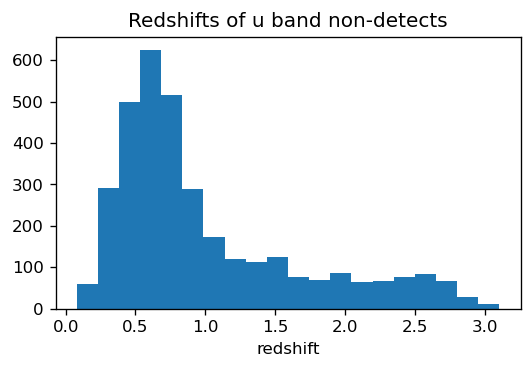

In [8]:
fig, ax = plt.subplots(figsize=(5,3), dpi=120)
ax.hist(y1_catalog_w_u_nodetects[np.isnan(y1_catalog_w_u_nodetects["u"])]["redshift"], bins=20)
ax.set(xlabel="redshift", title="Redshifts of u band non-detects")
plt.show()

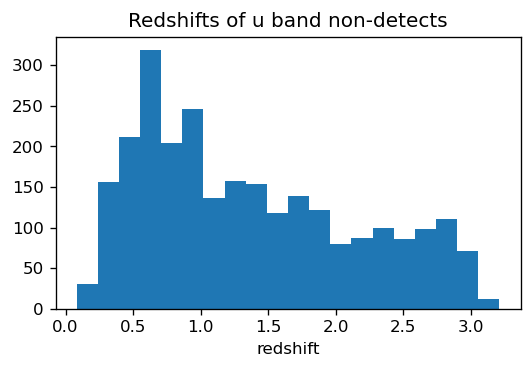

In [9]:
fig, ax = plt.subplots(figsize=(5,3), dpi=120)
ax.hist(y10_catalog_w_u_nodetects[np.isnan(y10_catalog_w_u_nodetects["u"])]["redshift"], bins=20)
ax.set(xlabel="redshift", title="Redshifts of u band non-detects")
plt.show()